In [30]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
import transformers
from evaluate import load
from transformers import BertTokenizerFast, AdamW, BertForQuestionAnswering, AutoTokenizer, AutoModelForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

In [31]:
# Configuration
class QAConfig:

    MODEL_NAME = "deepset/bert-base-uncased-squad2"
    MAX_SEQ_LENGTH = 512

    # Training settings
    BATCH_SIZE = 16
    LEARNING_RATE = 2e-5
    WEIGHT_DECAY = 2e-2
    NUM_EPOCHS = 3

    # File names
    TRAIN_FILE = "spoken_train-v1.1.json"
    TEST_FILE = "spoken_test-v1.1.json"
    TEST_FILE_WER44 = "spoken_test-v1.1_WER44.json"
    TEST_FILE_WER54 = "spoken_test-v1.1_WER54.json"

    # Output files
    PLOT_FILE = "training_metrics_bert_pretrained.png"

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
# Data Loading Function
def load_squad_data(path):
    contexts = []
    questions = []
    answers = []

    with open(path, 'rb') as file:
        raw_data = json.load(file)

    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)

    return contexts, questions, answers

In [33]:
# Loading training data
train_contexts, train_questions, train_answers = load_squad_data(QAConfig.TRAIN_FILE)
print(f"Training Data: {train_questions[0]}, {train_answers[0]}")

# Loading testing data
test_contexts, test_questions, test_answers = load_squad_data(QAConfig.TEST_FILE)
print(f"Testing Data: {test_questions[0]}, {test_answers[0]}")

# Loading testing WER 44 data
test_contexts_44, test_questions_44, test_answers_44 = load_squad_data(QAConfig.TEST_FILE_WER44)
print(f"Testing Data_44: {test_questions_44[0]}, {test_answers_44[0]}")

# Loading testing WER 54 data
test_contexts_54, test_questions_54, test_answers_54 = load_squad_data(QAConfig.TEST_FILE_WER54)
print(f"Testing Data_54: {test_questions_54[0]}, {test_answers_54[0]}")

Training Data: what is in front of the notre dame main building?, {'answer_start': 187, 'text': 'a copper statue of christ'}
Testing Data: which nfl team represented the afc at super bowl 50?, {'answer_start': 190, 'text': 'denver broncos'}
Testing Data_44: which nfl team represented the afc at super bowl 50?, {'answer_start': 177, 'text': 'Denver Broncos'}
Testing Data_54: which nfl team represented the afc at super bowl 50?, {'answer_start': 177, 'text': 'Denver Broncos'}


In [34]:
# Computing Answer Boundaries
def compute_answer_boundaries(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].lower()
        expected_answer = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(expected_answer)

        if context[start_idx:end_idx] == expected_answer:
            answer['answer_end'] = end_idx
        else:
            for offset in [1, 2]:
                if context[start_idx - offset:end_idx - offset] == expected_answer:
                    answer['answer_start'] = start_idx - offset
                    answer['answer_end'] = end_idx - offset
                    break


compute_answer_boundaries(train_answers, train_contexts)
compute_answer_boundaries(test_answers, test_contexts)
compute_answer_boundaries(test_answers_44, test_contexts_44)
compute_answer_boundaries(test_answers_54, test_contexts_54)

In [35]:
# Applying Answer Boundary Computation
compute_answer_boundaries(train_answers, train_contexts)
compute_answer_boundaries(test_answers, test_contexts)
compute_answer_boundaries(test_answers_44, test_contexts_44)
compute_answer_boundaries(test_answers_44, test_contexts_44)

In [36]:
# Initializing Tokenizer and Tokenize Data

tokenizer = AutoTokenizer.from_pretrained(QAConfig.MODEL_NAME)

train_encodings = tokenizer(train_questions, train_contexts,
                          max_length=QAConfig.MAX_SEQ_LENGTH,
                          truncation=True,
                          padding=True)

test_encodings = tokenizer(test_questions, test_contexts,
                         max_length=QAConfig.MAX_SEQ_LENGTH,
                         truncation=True,
                         padding=True)

test_encodings_44 = tokenizer(test_questions_44, test_contexts_44,
                            max_length=QAConfig.MAX_SEQ_LENGTH,
                            truncation=True,
                            padding=True)

test_encodings_54 = tokenizer(test_questions_54, test_contexts_54,
                            max_length=QAConfig.MAX_SEQ_LENGTH,
                            truncation=True,
                            padding=True)

In [37]:
# Extracting Answer Positions Function

def extract_answer_positions(encodings, answers, tokenizer):
    start_positions = []
    end_positions = []

    for idx in range(len(encodings['input_ids'])):
        answer_text = answers[idx]['text']
        answer_encoding = tokenizer(answer_text,
                                  max_length=QAConfig.MAX_SEQ_LENGTH,
                                  truncation=True,
                                  padding=True)

        found_start = False
        for a in range(len(encodings['input_ids'][idx]) - len(answer_encoding['input_ids'])):
            match = True
            for i in range(1, len(answer_encoding['input_ids'])-1):
                if answer_encoding['input_ids'][i] != encodings['input_ids'][idx][a + i]:
                    match = False
                    break
            if match:
                start_positions.append(a)
                end_positions.append(a + len(answer_encoding['input_ids']) - 1)
                found_start = True
                break
        if not found_start:
            start_positions.append(0)
            end_positions.append(0)

    return start_positions, end_positions

In [38]:
# Updating train encodings
train_start_positions, train_end_positions = extract_answer_positions(train_encodings, train_answers, tokenizer)
train_encodings.update({'start_positions': train_start_positions,
                       'end_positions': train_end_positions})

# Updating test encodings
test_start_positions, test_end_positions = extract_answer_positions(test_encodings, test_answers, tokenizer)
test_encodings.update({'start_positions': test_start_positions,
                      'end_positions': test_end_positions})

# Updating test WER 44 encodings
test_start_positions_44, test_end_positions_44 = extract_answer_positions(test_encodings_44, test_answers_44, tokenizer)
test_encodings_44.update({'start_positions': test_start_positions_44,
                         'end_positions': test_end_positions_44})

# Updating test WER 54 encodings
test_start_positions_54, test_end_positions_54 = extract_answer_positions(test_encodings_54, test_answers_54, tokenizer)
test_encodings_54.update({'start_positions': test_start_positions_54,
                         'end_positions': test_end_positions_54})

In [39]:
# Implemented Class for Dataset
class QADataset(Dataset):
    def __init__(self, encodings):
        self.input_ids = torch.tensor(encodings['input_ids'])
        self.token_type_ids = torch.tensor(encodings['token_type_ids'])
        self.attention_mask = torch.tensor(encodings['attention_mask'])
        self.start_positions = torch.tensor(encodings['start_positions'])
        self.end_positions = torch.tensor(encodings['end_positions'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'token_type_ids': self.token_type_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'start_positions': self.start_positions[idx],
            'end_positions': self.end_positions[idx]
        }

    def __len__(self):
        return len(self.input_ids)

In [40]:
# Creating Dataset Instances and  from encodings
train_dataset = QADataset(train_encodings)
test_dataset = QADataset(test_encodings)
test_dataset_44 = QADataset(test_encodings_44)
test_dataset_54 = QADataset(test_encodings_54)

In [41]:
# Loading Pre-trained Model

qa_model = AutoModelForQuestionAnswering.from_pretrained(QAConfig.MODEL_NAME)

In [42]:
# Training Function

def train_qa_model(model, train_dataloader, num_epochs=QAConfig.NUM_EPOCHS):
    model.to(QAConfig.DEVICE)
    model.train()

    optimizer = AdamW(model.parameters(),
                     lr=QAConfig.LEARNING_RATE,
                     weight_decay=QAConfig.WEIGHT_DECAY)

    training_losses = []
    training_accuracies = []

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_accuracies = []
        with tqdm(train_dataloader, desc=f'Epoch {epoch+1}') as t:

            for batch in t:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(QAConfig.DEVICE)
                attention_mask = batch['attention_mask'].to(QAConfig.DEVICE)
                token_type_ids = batch['token_type_ids'].to(QAConfig.DEVICE)
                start_positions = batch['start_positions'].to(QAConfig.DEVICE)
                end_positions = batch['end_positions'].to(QAConfig.DEVICE)

                outputs = model(input_ids,
                              attention_mask=attention_mask,
                              start_positions=start_positions,
                              token_type_ids=token_type_ids,
                              end_positions=end_positions)

                loss = outputs[0]
                loss.backward()
                optimizer.step()

                # Calculate accuracy
                start_logits, end_logits = outputs[1], outputs[2]
                start_pred = start_logits.argmax(dim=1)
                end_pred = end_logits.argmax(dim=1)
                accuracy = ((start_pred == start_positions).float().mean() +
                          (end_pred == end_positions).float().mean()) / 2

                epoch_losses.append(loss.item())
                epoch_accuracies.append(accuracy.item())

                t.set_postfix_str(f'Loss: {loss.item():.4f}, Acc: {accuracy.item():.4f}')

        training_losses.append(np.mean(epoch_losses))
        training_accuracies.append(np.mean(epoch_accuracies))

    return training_losses, training_accuracies

In [43]:
# Training Model
train_dataloader = DataLoader(train_dataset, batch_size=QAConfig.BATCH_SIZE, shuffle=True)
training_losses, training_accuracies = train_qa_model(qa_model, train_dataloader)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 3: 100%|██████████| 2320/2320 [11:51<00:00,  3.26it/s, Loss: 0.3577, Acc: 0.8571]


In [44]:
# Evaluation Metrics Function
def compute_qa_metrics(predictions, references):
    # Calculating F1
    f1_scores = []
    # Calculating EM
    em_scores = []

    for pred, ref in zip(predictions, references):
        common = Counter(pred.split()) & Counter(ref.split())
        num_same = sum(common.values())
        if num_same == 0:
            precision = recall = f1 = 0
        else:
            precision = num_same / len(pred.split())
            recall = num_same / len(ref.split())
            f1 = (2 * precision * recall) / (precision + recall)
        f1_scores.append(f1)

        em = 1.0 if pred.strip() == ref.strip() else 0.0
        em_scores.append(em)

    avg_f1_score = (sum(f1_scores) / len(f1_scores)) * 100
    avg_em_score = (sum(em_scores) / len(em_scores)) * 100
    return avg_f1_score, avg_em_score

In [45]:
# Evaluating Model

def evaluate_qa_model(model, test_dataloader):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(QAConfig.DEVICE)
            attention_mask = batch['attention_mask'].to(QAConfig.DEVICE)
            token_type_ids = batch['token_type_ids'].to(QAConfig.DEVICE)
            start_positions = batch['start_positions'].to(QAConfig.DEVICE)
            end_positions = batch['end_positions'].to(QAConfig.DEVICE)

            outputs = model(input_ids,
                          attention_mask=attention_mask,
                          start_positions=start_positions,
                          token_type_ids=token_type_ids,
                          end_positions=end_positions)

            start_logits, end_logits = outputs[1], outputs[2]
            start_pred = start_logits.argmax(dim=1)
            end_pred = end_logits.argmax(dim=1)

            for i in range(len(start_pred)):
                start = start_pred[i].item()
                end = end_pred[i].item()
                predictions.append(tokenizer.decode(batch['input_ids'][i][start:end+1]))
                references.append(tokenizer.decode(batch['input_ids'][i][batch['start_positions'][i]:batch['end_positions'][i]+1]))

    f1_score, em_score = compute_qa_metrics(predictions, references)
    return f1_score, em_score


Question Answering Evaluation Results

Evaluating on No Noise test set...
Evaluating on WER 44 test set...
Evaluating on WER 54 test set...

Final Results:

Results for No Noise:
F1 Score: 73.03%
EM Score: 51.09%

Results for WER 44:
F1 Score: 41.26%
EM Score: 29.11%

Results for WER 54:
F1 Score: 31.11%
EM Score: 22.99%

Evaluation completed successfully.


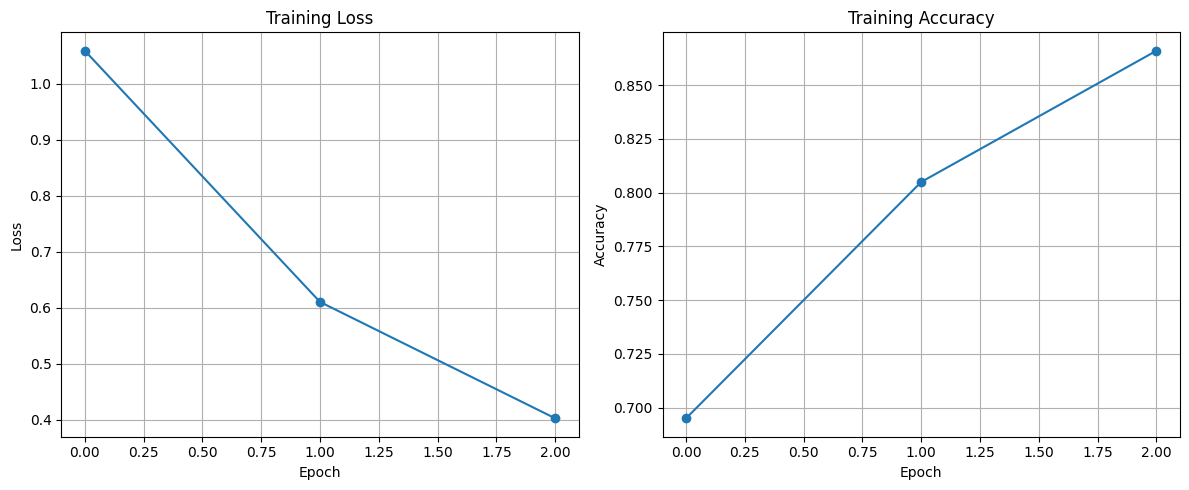


Results saved to qa_evaluation_results_bert.txt
Training curves saved to training_metrics_bert_pretrained.png


In [46]:
# Evaluating and Saving Results

test_dataloader = DataLoader(test_dataset, batch_size=QAConfig.BATCH_SIZE)
test_dataloader_44 = DataLoader(test_dataset_44, batch_size=QAConfig.BATCH_SIZE)
test_dataloader_54 = DataLoader(test_dataset_54, batch_size=QAConfig.BATCH_SIZE)

test_sets = [
    ("No Noise", test_dataloader),
    ("WER 44", test_dataloader_44),
    ("WER 54", test_dataloader_54)
]

all_results = {}

print("\nQuestion Answering Evaluation Results")
print("===================================\n")

with open('qa_evaluation_results_pretrained_bert.txt', 'w') as f:
    f.write("Question Answering Evaluation Results\n")
    f.write("===================================\n\n")

    for test_name, test_loader in test_sets:
        print(f"Evaluating on {test_name} test set...")
        f1_score, em_score = evaluate_qa_model(qa_model, test_loader)

        all_results[test_name] = {'f1': f1_score, 'em': em_score}

        f.write(f"Results for {test_name}:\n")
        f.write(f"F1 Score: {f1_score:.2f}%\n")
        f.write(f"EM Score: {em_score:.2f}%\n\n")

    f.write("===================================\n")
    f.write("Evaluation completed successfully.\n")


print("\nFinal Results:")
print("===================================")
for test_name in all_results:
    print(f"\nResults for {test_name}:")
    print(f"F1 Score: {all_results[test_name]['f1']:.2f}%")
    print(f"EM Score: {all_results[test_name]['em']:.2f}%")

print("\n===================================")
print("Evaluation completed successfully.")


plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(training_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig(QAConfig.PLOT_FILE)
plt.show()
plt.close()

print(f"\nResults saved to qa_evaluation_results_bert.txt")
print(f"Training curves saved to {QAConfig.PLOT_FILE}")